In [1]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

In [2]:
# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

domain = "openai.com" # <- put your domain to be crawled
full_url = "https://openai.com/" # <- put your domain to be crawled with https or http

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

In [3]:
# Function to get the hyperlinks from a URL
def get_hyperlinks(url):

    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []

            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

In [4]:
# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

In [5]:
def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        try:
            # Save text from the url to a <url>.txt file
            with open('text/'+local_domain+'/'+url[8:].replace("/", "_").replace("?", "_") + ".txt", "w", encoding="UTF-8") as f:

                # Get the text from the URL using BeautifulSoup
                soup = BeautifulSoup(requests.get(url).text, "html.parser")

                # Get the text but remove the tags
                text = soup.get_text()

                # If the crawler gets to a page that requires JavaScript, it will stop the crawl
                if ("You need to enable JavaScript to run this app." in text):
                    print("Unable to parse page " + url + " due to JavaScript being required")
            
                # Otherwise, write the text to the file in the text directory
                f.write(text)
        except Exception as e:
            print("Unable to parse page " + url)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)

https://openai.com/
https://openai.com/safety
https://openai.com/blog/best-practices-for-deploying-language-models
https://openai.com/blog/best-practices-for-deploying-language-models#OpenAI
https://openai.com/blog?topics=safety-alignment
https://openai.com/blog/custom-instructions-for-chatgpt
https://openai.com/blog?topics=product
https://openai.com/blog?topics=announcements
https://openai.com/blog/custom-instructions-for-chatgpt#OpenAI
https://openai.com/blog/custom-instructions-for-chatgpt#content
https://openai.com/policies/usage-policies
https://openai.com/api/policies/sharing-publication
https://openai.com/policies/sharing-publication-policy#content
https://openai.com/form/researcher-access-program
https://openai.com/policies/sharing-publication-policy#research
https://openai.com/form/researcher-access-program#content
https://openai.com/policies/coordinated-vulnerability-disclosure-policy
https://openai.com/security.txt
https://openai.com/policies/coordinated-vulnerability-disclo

In [6]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [7]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

,fname,text
0,,. OpenAI CloseSearch Submit Skip to main c...
1,#content,#content. OpenAI CloseSearch Submit Skip t...
2,,. OpenAI CloseSearch Submit Skip to main c...
3,about#content,about#content. About CloseSearch Submit Sk...
4,about,about. About CloseSearch Submit Skip to ma...


<Axes: >

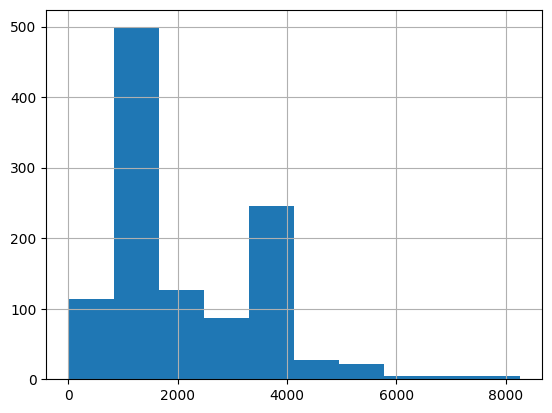

In [9]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [10]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks


shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])

    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<Axes: >

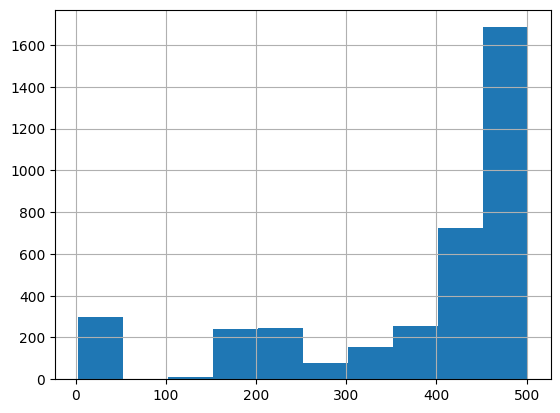

In [11]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [12]:
from openai import OpenAI

client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

df['embeddings'] = df.text.apply(lambda x: client.embeddings.create(input=x, model='text-embedding-ada-002').data[0].embedding)

df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,. OpenAI CloseSearch Submit Skip to main c...,489,"[0.0026194904930889606, -0.027867799624800682,..."
1,#content. OpenAI CloseSearch Submit Skip t...,491,"[0.003062105504795909, -0.028499417006969452, ..."
2,. OpenAI CloseSearch Submit Skip to main c...,489,"[0.0026194904930889606, -0.027867799624800682,..."
3,about#content. About CloseSearch Submit Sk...,493,"[-0.0005569123313762248, -0.023880677297711372..."
4,about. About CloseSearch Submit Skip to ma...,491,"[0.002552515361458063, -0.02382577396929264, -..."


In [13]:
from scipy.spatial.distance import cosine

def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = client.embeddings.create(input=question, model='text-embedding-ada-002').data[0].embedding

    # Get the distances from the embeddings
    # df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')
    df["distances"] = df["embeddings"].apply(lambda x: cosine(q_embeddings, x))


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():

        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4

        # If the context is too long, break
        if cur_len > max_len:
            break

        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [14]:
def answer_question(
    df,
    model="gpt-3.5-turbo",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a chat completion using the question and context
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\n"},
                {"role": "user", "content": f"Context: {context}\n\n---\n\nQuestion: {question}\nAnswer:"}
            ],
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
        )
        return response.choices[0].message.content
    except Exception as e:
        print(e)
        return ""

In [15]:
print(answer_question(df, question="What day is it?"))

I don't know.


In [16]:
print(answer_question(df, question="What is our newest embeddings model?"))

The newest embeddings model is text-embedding-ada-002.


In [17]:
print(answer_question(df, question="What is ChatGPT?"))

ChatGPT is a model developed by OpenAI that interacts in a conversational way. It is trained to answer follow-up questions, admit mistakes, challenge incorrect premises, and reject inappropriate requests. It is a sibling model to InstructGPT and is designed to provide detailed responses based on prompts.
